### <center><font color = #03989e>DATA3001 - Protolytix 🧬</font></center>
<center><center><center><center><center><font color = #03989e>Dharani Palanisamy (z5260276)</font></center>
<center><center><center><center><font color = #03989e>Faiyam Islam (z5258151)</font></center></center></center></center>
<center><center><center><font color = #03989e>Hilary Cao (z5308506)</font></center></center></center>
<center><center><font color = #03989e>Kelly Tao (z5259876)</font></center></center>
<center><font color = #03989e>Pooja Saianand (z5312416)</font></center>

In [1]:
# pip install kneed

-------------------------------------------------------------------------------------------------------------------------------
#### <center><font color = #03989e>Importing Packages</font></center>
-------------------------------------------------------------------------------------------------------------------------------

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns
import sklearn as sk
from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
#import statsmodels.api as sm
#import statsmodels.formula.api as smf
import os
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

-------------------------------------------------------------------------------------------------------------------------------
#### <center><font color = #03989e>Proteins dataset</font></center>
-------------------------------------------------------------------------------------------------------------------------------

In [3]:
data = pd.read_csv('AF-O43526-F1-model_v3.tsv', sep='\t', header=0)
df = pd.DataFrame(data)
df1 = df.drop(columns=['index', 'gamma', 'exp', 'obs'])
df1

,x,y,z
0,-3.512,-33.674,-14.723
1,-1.390,-34.119,-11.579
2,1.629,-36.312,-11.147
3,4.865,-35.872,-9.157
4,7.371,-38.625,-8.349
...,...,...,...
867,-12.577,-52.381,-22.296
868,-10.479,-51.784,-19.900
869,-6.981,-50.668,-18.703
870,-3.920,-51.828,-16.712


-------------------------------------------------------------------------------------------------------------------------------
#### <center><font color = #03989e>kNN Implementation to retrieve distance matrix</font></center>
-------------------------------------------------------------------------------------------------------------------------------

In [4]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
def get_distance(data, k):
    nearest_neighbors = NearestNeighbors(n_neighbors=k)
    neighbors = nearest_neighbors.fit(data)

    distances, indices = neighbors.kneighbors(data)
    distances = np.sort(distances[:,(k-1)], axis=0)
    
    return distances

In [5]:
from kneed import KneeLocator
# to find epislon value
def knee_val(distances):
    i = np.arange(len(distances))
    knee = KneeLocator(i, distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')
    return distances[knee.knee]

-------------------------------------------------------------------------------------------------------------------------------
#### <center><font color = #03989e>DBSCAN Implementation</font></center>
-------------------------------------------------------------------------------------------------------------------------------

In [6]:
from sklearn.cluster import DBSCAN
from collections import Counter
def dbscan(eps_Val, min_samples_Val, data):
        dbscan = DBSCAN(eps=eps_Val, min_samples=min_samples_Val).fit(df1)
        labels = dbscan.labels_

        from collections import Counter
        t = Counter(labels)
        cluster_category = [] #stores the different clusters dbscane has created
        cluster_weight = [] #stores the total number of data points that belond to a specific cluster from cluster_category
        for i in t:
                cluster_category.append(i)
                cluster_weight.append(t[i])
        #print(y, z)
        return labels, cluster_category, cluster_weight

-------------------------------------------------------------------------------------------------------------------------------
#### <center><font color = #03989e>Computing gamma value for each cluster</font></center>
-------------------------------------------------------------------------------------------------------------------------------

In [7]:
def calculate_gamma(labels, df, cluster_category, cluster_weight):    
    gammas = [] #stores the gamma value for each cluster calculated using avg ecpected and avg observed
    for i in cluster_category:
        index_val = cluster_category.index(i)
        total = cluster_weight[index_val]
        sum_exp = 0
        sum_obs = 0
        for j in range(len(labels)):
            #get the sum of expected and observed values for each cluster
            if labels[j] == i:
                # Now get the expected and observed value for amino acid with index j
                expected_val = df.iloc[j,5]
                obs_Val = df.iloc[j,6]
                sum_exp += expected_val
                sum_obs += obs_Val
        #print(sum_obs,sum_exp)
        avg_exp = (sum_exp*1.0)/total
        avg_obs = (sum_obs*1.0)/total
        gamma_val = avg_obs/avg_exp
        gammas.append(gamma_val)
                
    #print(gammas)
    #find average  gamma value of the entire model
    sum_gamma = 0
    for i in gammas:
        sum_gamma += i
    avg_gamma = (sum_gamma*1.0/len(gammas))
    return avg_gamma, gammas

In [8]:
#Putting it all together
# min_samples = 2*dimensions
count = 0
min_gamma = 0
store_labels = 0
min_gammas = []
min_point = 0
store_distances = [] # KNN output used to find the knee value point (Epsilon value) to perform DBSCAN
for min_val in range(4,len(df1)):
    distances = get_distance(df1, min_val-1) #knn
    #plot_function(distances)
    eps_Val = knee_val(distances) 
    #for i in range(min_val, len(df1)):
    labels,cluster_category,cluster_weight = dbscan(eps_Val, min_val, df1)
    #print(cluster_category)
    if len(cluster_category) > 2:
        gamma_val, gammas = calculate_gamma(labels, df, cluster_category, cluster_weight)
        #print(gamma_val)
        if min_gamma == 0:
            store_distances = distances
            min_gamma = gamma_val
            store_labels = labels
            min_point = min_val-1
            min_gammas = gammas
        elif gamma_val < min_gamma:
            store_distances = distances
            min_gamma = gamma_val
            store_labels = labels
            min_point = min_val-1
            min_gammas = gammas
# finding the minimum cluster
print(min_gamma)
#print(len(Counter(store_labels)))
#print(min_gammas)
#print(store_labels)
#print(min_point)

0.4288679978074875


In [9]:
print(f"The overall minimum average gamma value of {min_gamma}")
print(f"The number of clusters produced by the DBSCAN clustering {len(Counter(store_labels))}")
print(f"List of minimum gamma values: {min_gammas}")
print(f"Count of the data points in each cluster:{Counter(store_labels)}")
print(f"Minimum point is {min_point}")
print(f"Epsilon value: {knee_val(store_distances)}")
#print(f"KNN output for knee value plot: {store_distances}")

The overall minimum average gamma value of 0.4288679978074875
The number of clusters produced by the DBSCAN clustering 5
List of minimum gamma values: [0.5963903396776727, 0.5057785914437981, 0.3826722554873264, 0.5259469283720811, 0.13355187405655922]
Count of the data points in each cluster:Counter({0: 553, -1: 265, 3: 26, 1: 14, 2: 14})
Minimum point is 7
Epsilon value: 10.693731107522758


-------------------------------------------------------------------------------------------------------------------------------
#### <center><font color = #03989e>Knee Plot</font></center>
-------------------------------------------------------------------------------------------------------------------------------

10.693731107522758


<Figure size 360x360 with 0 Axes>

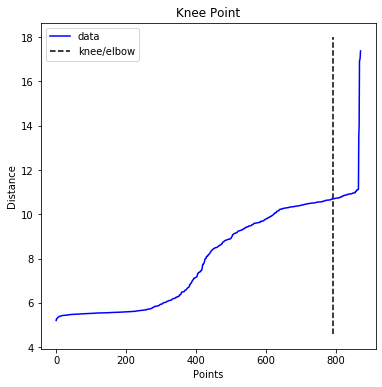

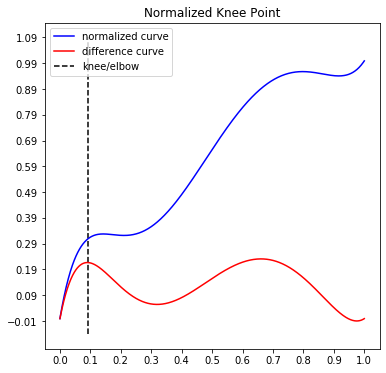

In [25]:
# To get the knee value plot:
i = np.arange(len(store_distances))
knee = KneeLocator(i, store_distances, S=1, curve='convex', direction='increasing', interp_method='polynomial')

fig = plt.figure(figsize=(5, 5))
knee.plot_knee()
plt.xlabel("Points")
plt.ylabel("Distance")
knee.plot_knee_normalized()
print(store_distances[knee.knee])

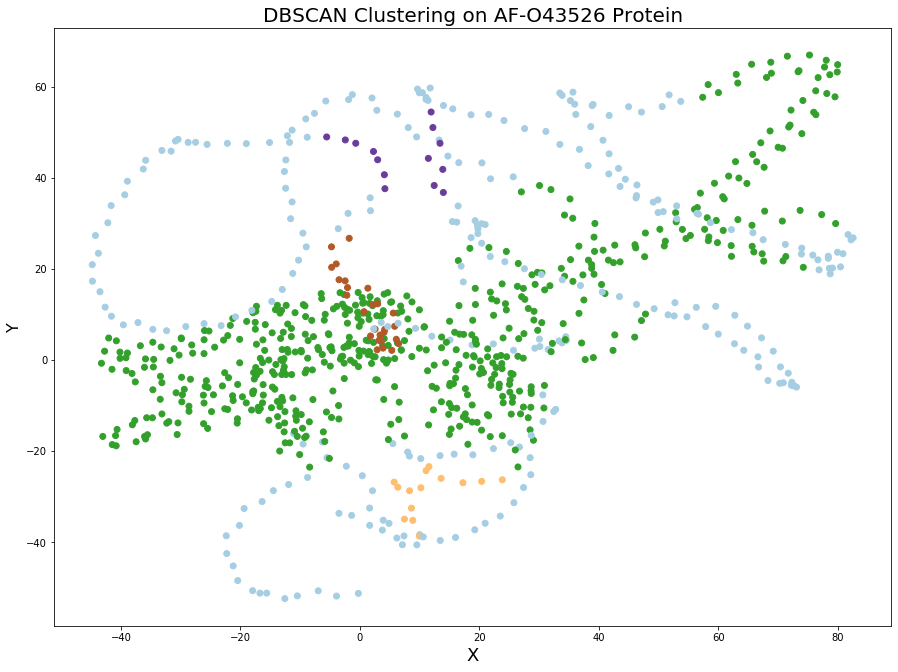

In [26]:
# To get the DBSCAN plot
plt.figure(figsize=(15, 11))
plt.scatter(df1.iloc[:, 0], df1.iloc[:, 1], c=store_labels, cmap='Paired')
plt.xlabel('X', fontsize=18)
plt.ylabel('Y', fontsize=16)
plt.title('DBSCAN Clustering on AF-O43526 Protein', fontsize=20)
plt.show()

In [24]:
X = df[['x', 'y', 'z']]
sil_scores = []
calinski_score = []
davies_score = []
 
db = DBSCAN(eps=10.693731107522758, min_samples=7)
labels = db.fit_predict(X)
sil_scores.append(silhouette_score(X, store_labels))
calinski_score.append(calinski_harabasz_score(X, store_labels))
davies_score.append(davies_bouldin_score(X, store_labels))
    
print('At K = 5')
print("Silhouette Coefficient: %0.3f" % silhouette_score(X, store_labels))
print("Calinski-Harabasz Index: %0.3f" % calinski_harabasz_score(X, store_labels))
print("Davies-Bouldin Index: %0.3f" % davies_bouldin_score(X, store_labels))

At K = 5
Silhouette Coefficient: -0.185
Calinski-Harabasz Index: 11.472
Davies-Bouldin Index: 4.057


-------------------------------------------------------------------------------------------------------------------------------
#### <center><font color = #03989e>End of Notebook</font></center>
-------------------------------------------------------------------------------------------------------------------------------